# Fluorence of a two-level atom

### installing & loading packages

In [ ]:
using Pkg

Pkg.add("QuantumOptics")
Pkg.add("CairoMakie")
Pkg.add("LaTeXStrings")
Pkg.add("Plots")
# Pkg.update()

In [1]:
using QuantumOptics
using CairoMakie
using LaTeXStrings

import Plots as P
colors=P.palette(:tab10)

## 1) Finding the steady-state

We first define the usefull quantites and the Hamiltonian
$$
H=-\frac{\hbar\delta}{2}\sigma_z +\frac{\hbar\Omega}{2}(\sigma_+ + \sigma_-),
$$
where $ \hbar \omega_0$ is the energy betewen de ground and the excited state , $\omega_l$ is the laser frequency, $\delta =\omega_L - \omega_0$ is the detuning and $\Omega$ the Rabi frenquency.
For computational reason, we will set $\hbar=1$.

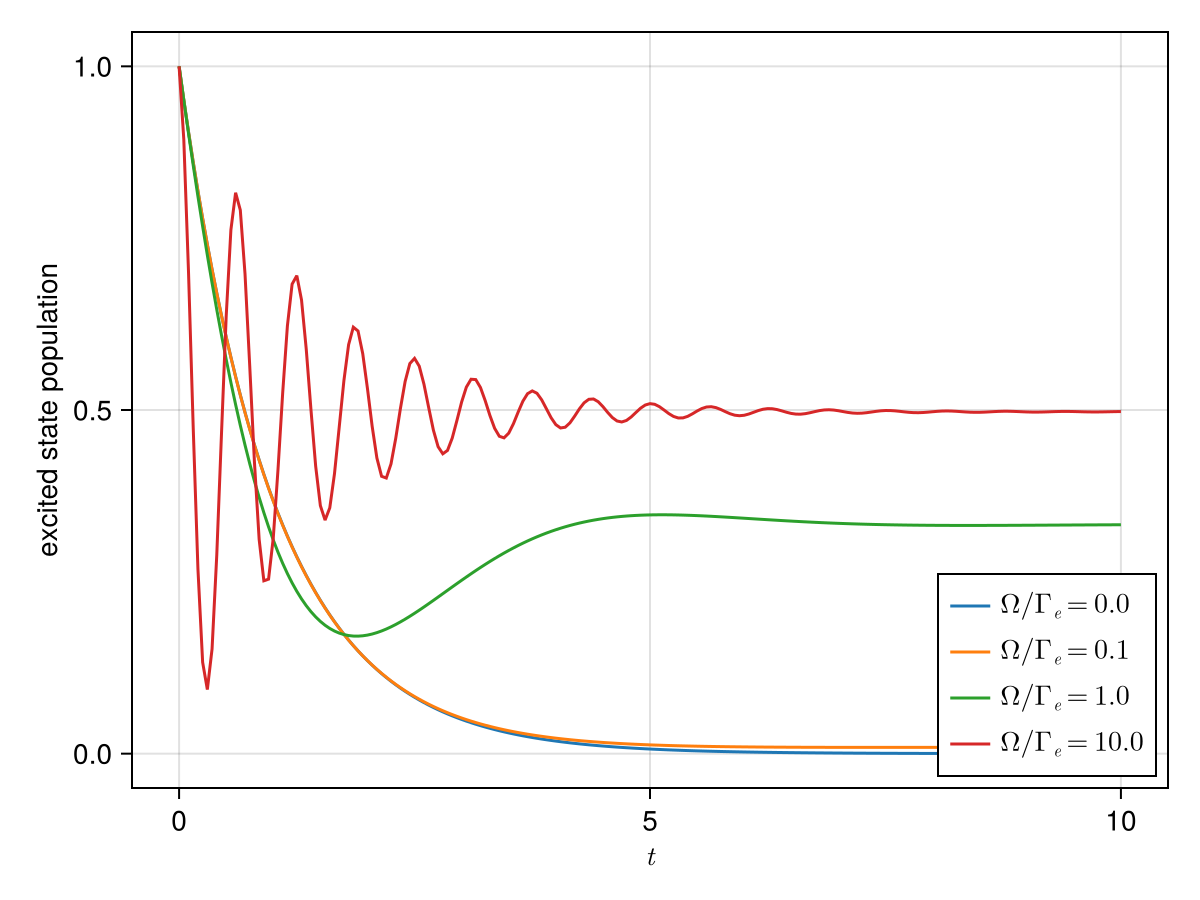

In [9]:
#basis
b = NLevelBasis(2)

#parameters
ω_L=1
ω_0=1
Ωs=[0,0.1, 1, 10]
δ=ω_L - ω_0

Γe=1

#Hamiltonian
σ_p=transition(b,2,1)
σ_m=transition(b,1,2)
σ_z=transition(b,2,2) - transition(b,1,1)

H(δ, Ω)=-(δ/2)*σ_z + (Ω/2)*(σ_p + σ_m)

#jump operators
J=[σ_m]

#rates  
rates=[Γe]

#initial state
ψ0 = nlevelstate(b,2)
# ρ0=tensor(ψ0,ψ0')

#time evolution
tspan = 0:0.05:10

#plot + computation
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"t", ylabel="excited state population")

for (i,Ω) in enumerate(Ωs)
    #time evolution
    tout, ψt=timeevolution.master(tspan,ψ0,H(δ, Ω),J,rates=rates)
    #expectation value
    exp_pt=real(expect(transition(b,2,2),ψt))
    #plotting
    lines!(ax, tspan, exp_pt, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end

axislegend(ax,position=:rb)
fig

# 2

# 3